Aim: predict age and gender from RFIW2021 data -- train and val sets.

1. Inspect MiVOLO to understand its setup
2. Copy the necessary code
3. Adapt it to save each prediction to a dataframe (maybe extending val.txt to have age and gender)
4. Analyse the generated dataframe

## Import libraries

In [1]:
import os
from dataclasses import dataclass
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from mivolo.data.data_reader import get_all_files
from mivolo.predictor import Predictor
from tqdm import tqdm

In [2]:
%load_ext jupyter_ai_magics

In [40]:
# *_, sk = !gpg --decrypt ~/.keys/openai.gpg

In [4]:
os.environ["OPENAI_API_KEY"] = sk

# Set up paths

In [5]:
try:
    IS_NOTEBOOK = True
    HERE = Path(__file__).resolve().parent
except NameError:
    IS_NOTEBOOK = False
    HERE = Path().resolve()

DATA_DIR = Path(HERE, "../rfiw2021/Track1/Validation/val-faces")
MODELS_DIR = Path(HERE, "../MiVOLO/models")

In [6]:
@dataclass
class Config:
    device: str = "cuda"
    detector_weights: str = MODELS_DIR / "yolov8x_person_face.pt"
    checkpoint: str = MODELS_DIR / "mivolo_imbd.pth.tar"
    with_persons: bool = False
    disable_faces: bool = False
    draw = False

In [ ]:
args = Config()
predictor = Predictor(args)

In [9]:
LOAD_PREDS = True
Path("data").mkdir(exist_ok=True)
ag_preds_csv_path = Path("data/age_gender_predictions.csv")
ag_preds_csv_path.exists()

True

In [10]:
if ag_preds_csv_path.exists() and LOAD_PREDS:
    ag_preds = pd.read_csv(ag_preds_csv_path)
else:
    image_files = get_all_files(DATA_DIR)

    preds = []

    for img_p in tqdm(image_files):
        img = cv2.imread(img_p)
        try:
            pred, out_im = predictor.recognize(img)
            gs = np.array(pred.gender_scores)
            gs[gs == None] = 0
            max_index = np.argmax(gs)
            if pred.ages[max_index] is None:
                pred_info = {"age": 0, "gender": "unk", "gender_score": 0}
            else:
                pred_info = {
                    "age": pred.ages[max_index],
                    "gender": pred.genders[max_index],
                    "gender_score": pred.gender_scores[max_index],
                }
        except:
            pred_info = {"age": 0, "gender": "unk", "gender_score": 0}
        img_info = {k: v for k, v in zip(["fid", "mid", "pid_filename"], Path(img_p).parts[-3:])}
        preds.append({**img_info, **pred_info})

    ag_preds = pd.DataFrame(preds)
    ag_preds.to_csv("data/age_gender_predictions.csv", index=False)

    print(f"Errors found: {len(ag_preds[ag_preds.age == 0])}")

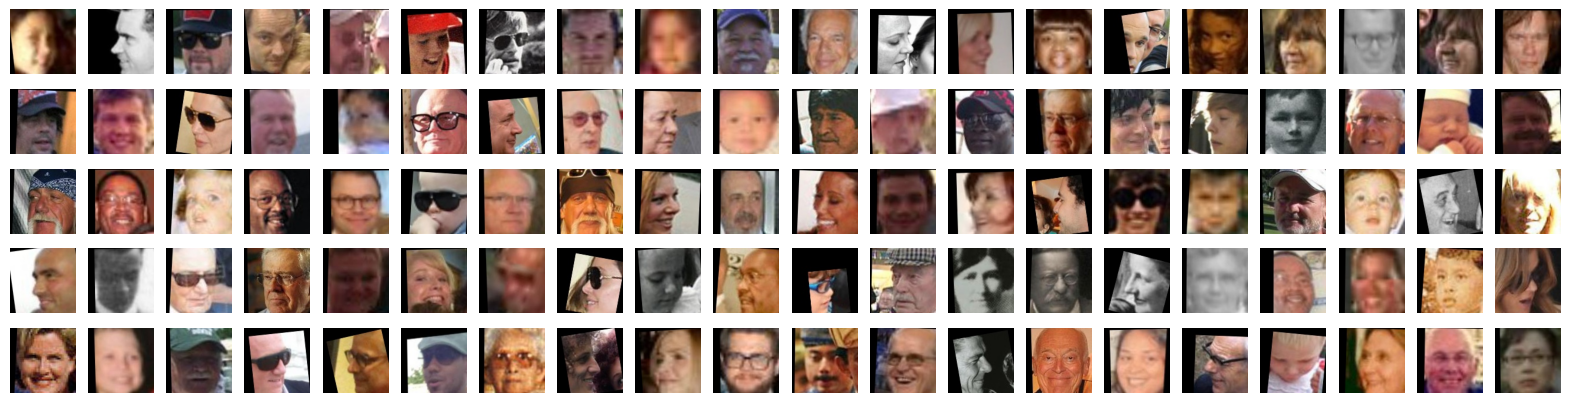

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 20, figsize=(20, 5))
axes = [ax for axes_ in axes for ax in axes_]

errors = ag_preds[ag_preds.gender == "unk"].sample(n=100).reset_index(drop=True)

for idx, row in errors.iterrows():
    img_fp = str(Path(DATA_DIR, row.fid, row.mid, row.pid_filename).resolve())
    img = cv2.imread(img_fp)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = axes[idx]
    ax.imshow(img)
    ax.axis("off")

plt.show()

# Data Analysis

- Age histogram for each kinship relation, for each face image
- Gender histogram for each kinship relation, for each face index

We are supposing that there are no intersections between faces in the pairs. That is, first faces aren't present as second faces in any other pair.

What I found while coding:

1. Face pairs with repeated faces are possible for face 1.

### Steps

1. Load validation pairs info into a dataframe: `val_pairs`
2. Extract FID, MID, filename to new columns
3. Merge age and gender predictions `ag_preds` with `val_pairs`
   - New dataframe will have: `face1_path, face2_path, kin_relation, is_kin, face1_family_id (fid1), face2_family_id (fid2), pid1_age, pid1_gender, pid2_age, pid2_gender`
4. Plot histograms: a unique plot with 2 subplots, where row 1 has age and row 2 has gender for both faces histogram densitys overlaid

## Plot data distribution

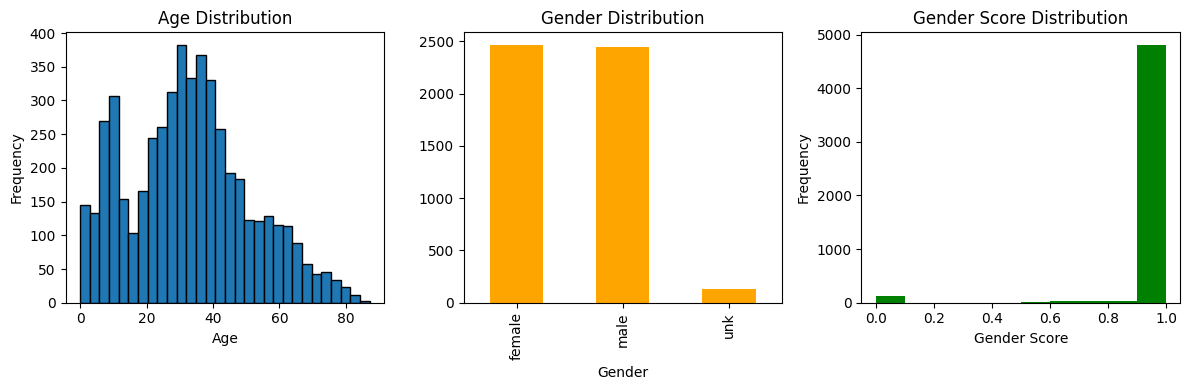

In [12]:
plt.figure(figsize=(12, 4))

# Plot for 'age'
plt.subplot(1, 3, 1)
ag_preds["age"].plot(kind="hist", bins=30, edgecolor="black")
plt.xlabel("Age")
plt.title("Age Distribution")

# Plot for 'gender'
plt.subplot(1, 3, 2)
ag_preds["gender"].value_counts().plot(kind="bar", color="orange")
plt.xlabel("Gender")
plt.title("Gender Distribution")

# Plot for 'gender_score'
plt.subplot(1, 3, 3)
ag_preds["gender_score"].plot(kind="hist", color="green")
plt.xlabel("Gender Score")
plt.title("Gender Score Distribution")

plt.tight_layout()
plt.show()

## Plot some 0-age samples

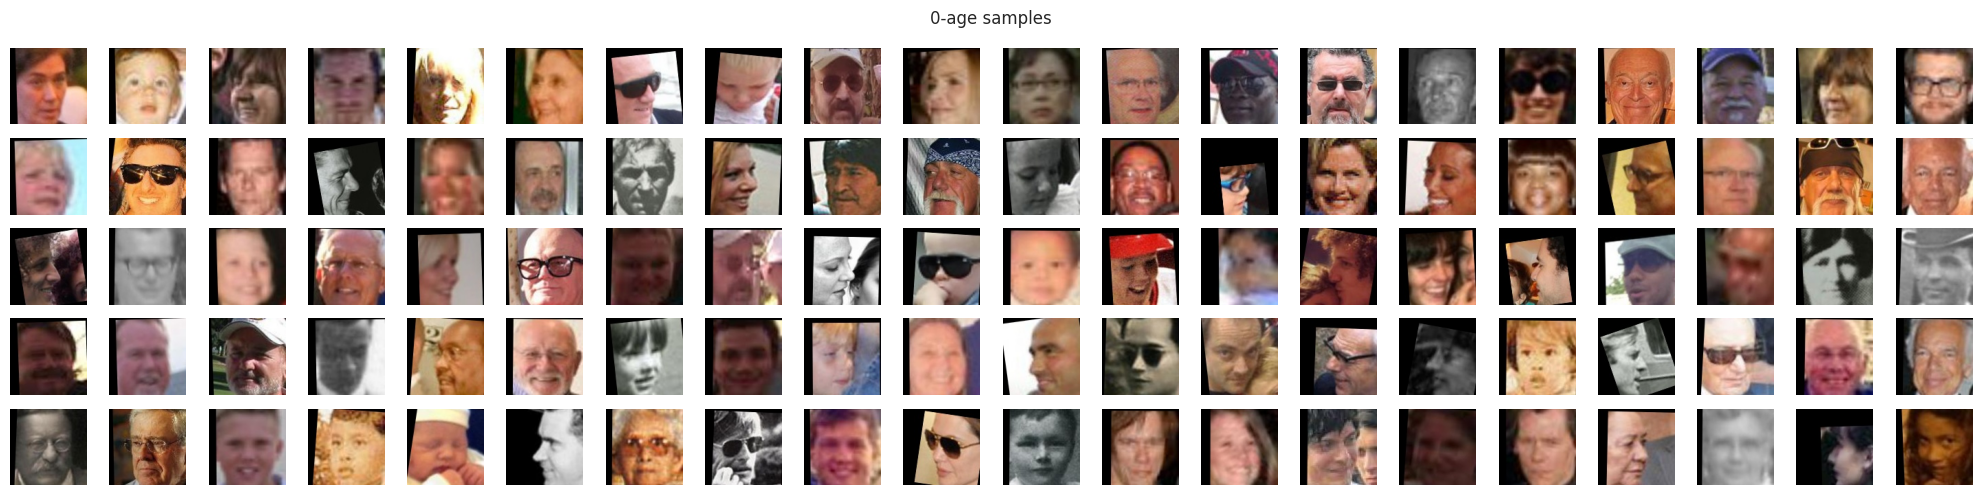

In [168]:
fig, axes = plt.subplots(5, 20, figsize=(20, 5))
axes = [ax for axes_ in axes for ax in axes_]

errors = ag_preds[ag_preds.age == 0].sample(n=100).reset_index(drop=True)

for idx, row in errors.iterrows():
    img_fp = str(Path(DATA_DIR, row.fid, row.mid, row.pid_filename).resolve())
    img = cv2.imread(img_fp)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = axes[idx]
    ax.imshow(img)
    ax.axis("off")

plt.suptitle("0-age samples")
plt.tight_layout()
plt.show()

[] [] []


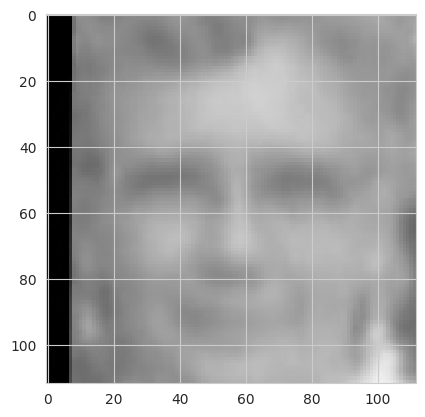

In [178]:
sample = errors.sample(n=1).iloc[0]
img_fp = str(Path(DATA_DIR, sample.fid, sample.mid, sample.pid_filename).resolve())
img = cv2.imread(img_fp)
results, _ = predictor.recognize(img)
print(results.ages, results.genders, results.gender_scores)
plot_img = results.plot(line_width=1, font_size=5)
plt.imshow(plot_img)

## Filter 0-age samples, then plot data distributions again

In [181]:
original_ag_preds = ag_preds.copy()
ag_preds = ag_preds[ag_preds.age != 0]

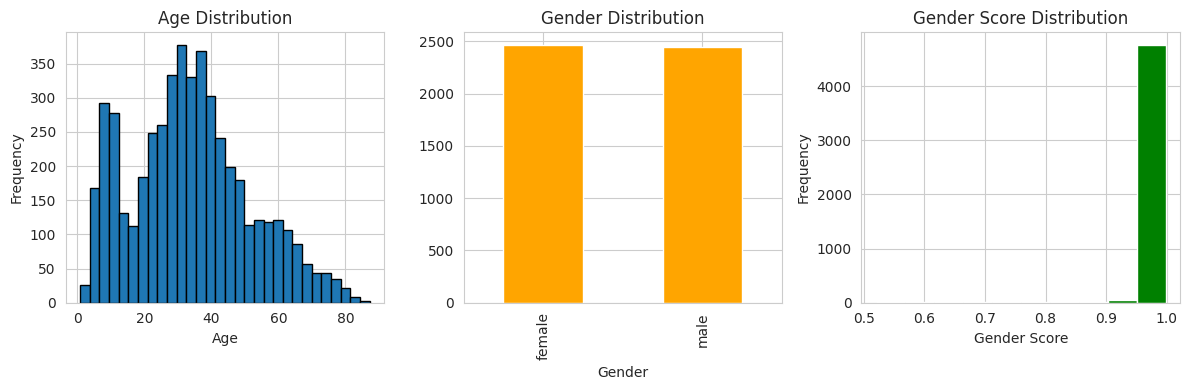

In [182]:
plt.figure(figsize=(12, 4))

# Plot for 'age'
plt.subplot(1, 3, 1)
ag_preds["age"].plot(kind="hist", bins=30, edgecolor="black")
plt.xlabel("Age")
plt.title("Age Distribution")

# Plot for 'gender'
plt.subplot(1, 3, 2)
ag_preds["gender"].value_counts().plot(kind="bar", color="orange")
plt.xlabel("Gender")
plt.title("Gender Distribution")

# Plot for 'gender_score'
plt.subplot(1, 3, 3)
ag_preds["gender_score"].plot(kind="hist", color="green")
plt.xlabel("Gender Score")
plt.title("Gender Score Distribution")

plt.tight_layout()
plt.show()

## Load validation pairs

In [33]:
def load_data(path: str):
    df = pd.read_csv(
        path,
        delimiter=" ",
        header=None,
        names=["id", "face1_path", "face2_path", "kin_relation", "is_kin"],
    )
    df.drop(["id"], inplace=True, axis=1)
    return df


val_pairs_fp = Path(HERE, "../rfiw2021/Track1/sample0/val.txt")
val_pairs_fp_model_sel = Path(HERE, "../rfiw2021/Track1/sample0/val_choose.txt")
val_pairs1 = load_data(val_pairs_fp)
val_pairs2 = load_data(val_pairs_fp_model_sel)
val_pairs = pd.concat([val_pairs1, val_pairs2]).reset_index(drop=True)
val_pairs

,face1_path,face2_path,kin_relation,is_kin
0,Validation/val-faces/F0007/MID1/P00075_face0.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1
1,Validation/val-faces/F0007/MID1/P00078_face3.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1
2,Validation/val-faces/F0007/MID1/P11275_face2.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1
3,Validation/val-faces/F0007/MID1/P00077_face12.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1
4,Validation/val-faces/F0007/MID1/P00082_face1.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1
...,...,...,...,...
105557,Validation/val-faces/F0422/MID1/P04458_face2.jpg,Validation/val-faces/F0422/MID3/P04453_face1.jpg,bb,1
105558,Validation/val-faces/F0990/MID5/P10431_face0.jpg,Validation/val-faces/F0990/MID9/P10435_face4.jpg,md,1
105559,Validation/val-faces/F0205/MID4/P02198_face1.jpg,Validation/val-faces/F0205/MID7/P02196_face1.jpg,fd,1
105560,Validation/val-faces/F0133/MID1/P01399_face1.jpg,Validation/val-faces/F0133/MID3/P09125_face1.jpg,fs,1


## Plot frequency by `kin_relation`

import matplotlib.pyplot as plt

/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/warley/.virtualenvs/kinship/lib/python3.11/site-packages/seaborn/_oldcore.py

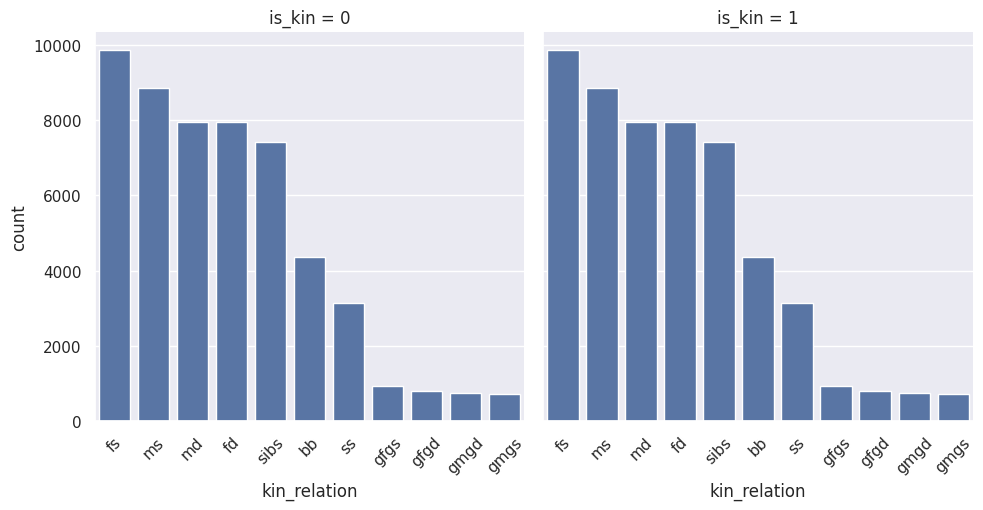

In [39]:
import seaborn as sns

sns.set(style="darkgrid")

# Calculate frequencies of 'kin_relation'
kin_relation_frequencies = val_pairs["kin_relation"].value_counts().index.tolist()

# Reorder 'kin_relation' based on frequency
val_pairs["kin_relation"] = pd.Categorical(val_pairs["kin_relation"], categories=kin_relation_frequencies, ordered=True)

grid = sns.FacetGrid(val_pairs, col="is_kin", height=5, aspect=1)
grid.map(sns.countplot, "kin_relation", order=kin_relation_frequencies)

# Rotate xlabels
grid.set_xticklabels(rotation=45)

plt.show()

In [38]:
kin_relation_frequencies

['fs', 'ms', 'md', 'fd', 'sibs', 'bb', 'ss', 'gfgs', 'gfgd', 'gmgd', 'gmgs']

### Add relevant columns to pairs dataframe

In [184]:
# Processing face1_path
face1_parts = val_pairs.face1_path.apply(lambda x: Path(x).parts[-3:])
val_pairs[["f1fid", "f1mid", "f1fp"]] = pd.DataFrame(face1_parts.tolist())

# Processing face2_path
face2_parts = val_pairs.face2_path.apply(lambda x: Path(x).parts[-3:])
val_pairs[["f2fid", "f2mid", "f2fp"]] = pd.DataFrame(face2_parts.tolist())
val_pairs

,face1_path,face2_path,kin_relation,is_kin,f1fid,f1mid,f1fp,f2fid,f2mid,f2fp
0,Validation/val-faces/F0007/MID1/P00075_face0.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00075_face0.jpg,F0007,MID9,P00079_face3.jpg
1,Validation/val-faces/F0007/MID1/P00078_face3.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00078_face3.jpg,F0007,MID9,P00079_face3.jpg
2,Validation/val-faces/F0007/MID1/P11275_face2.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P11275_face2.jpg,F0007,MID9,P00079_face3.jpg
3,Validation/val-faces/F0007/MID1/P00077_face12.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00077_face12.jpg,F0007,MID9,P00079_face3.jpg
4,Validation/val-faces/F0007/MID1/P00082_face1.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00082_face1.jpg,F0007,MID9,P00079_face3.jpg
...,...,...,...,...,...,...,...,...,...,...
105557,Validation/val-faces/F0422/MID1/P04458_face2.jpg,Validation/val-faces/F0422/MID3/P04453_face1.jpg,bb,1,F0422,MID1,P04458_face2.jpg,F0422,MID3,P04453_face1.jpg
105558,Validation/val-faces/F0990/MID5/P10431_face0.jpg,Validation/val-faces/F0990/MID9/P10435_face4.jpg,md,1,F0990,MID5,P10431_face0.jpg,F0990,MID9,P10435_face4.jpg
105559,Validation/val-faces/F0205/MID4/P02198_face1.jpg,Validation/val-faces/F0205/MID7/P02196_face1.jpg,fd,1,F0205,MID4,P02198_face1.jpg,F0205,MID7,P02196_face1.jpg
105560,Validation/val-faces/F0133/MID1/P01399_face1.jpg,Validation/val-faces/F0133/MID3/P09125_face1.jpg,fs,1,F0133,MID1,P01399_face1.jpg,F0133,MID3,P09125_face1.jpg


### Merge pairs dataframe with age and gender predictions dataframe

In [185]:
val_pairs = val_pairs.merge(
    ag_preds, left_on=["f1fid", "f1mid", "f1fp"], right_on=["fid", "mid", "pid_filename"], how="inner"
)
val_pairs.rename(columns={"age": "f1_age", "gender": "f1_gender", "gender_score": "f1_gender_score"}, inplace=True)
val_pairs.drop(["fid", "mid", "pid_filename"], axis=1, inplace=True)
val_pairs = val_pairs.merge(
    ag_preds, left_on=["f2fid", "f2mid", "f2fp"], right_on=["fid", "mid", "pid_filename"], how="inner"
)
val_pairs.rename(columns={"age": "f2_age", "gender": "f2_gender", "gender_score": "f2_gender_score"}, inplace=True)
val_pairs.drop(["fid", "mid", "pid_filename"], axis=1, inplace=True)
val_pairs

,face1_path,face2_path,kin_relation,is_kin,f1fid,f1mid,f1fp,f2fid,f2mid,f2fp,f1_age,f1_gender,f1_gender_score,f2_age,f2_gender,f2_gender_score
0,Validation/val-faces/F0007/MID1/P00075_face0.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00075_face0.jpg,F0007,MID9,P00079_face3.jpg,61.14,male,0.99707,10.2,female,0.712402
1,Validation/val-faces/F0007/MID1/P00078_face3.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00078_face3.jpg,F0007,MID9,P00079_face3.jpg,54.70,male,0.99707,10.2,female,0.712402
2,Validation/val-faces/F0007/MID1/P11275_face2.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P11275_face2.jpg,F0007,MID9,P00079_face3.jpg,27.06,male,0.99707,10.2,female,0.712402
3,Validation/val-faces/F0007/MID1/P11275_face2.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P11275_face2.jpg,F0007,MID9,P00079_face3.jpg,27.06,male,0.99707,10.2,female,0.712402
4,Validation/val-faces/F0007/MID1/P00082_face1.jpg,Validation/val-faces/F0007/MID9/P00079_face3.jpg,sibs,1,F0007,MID1,P00082_face1.jpg,F0007,MID9,P00079_face3.jpg,29.85,male,0.99707,10.2,female,0.712402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99968,Validation/val-faces/F0986/MID8/P10390_face2.jpg,Validation/val-faces/F0986/MID1/P10390_face5.jpg,ms,1,F0986,MID8,P10390_face2.jpg,F0986,MID1,P10390_face5.jpg,60.59,female,0.99707,33.0,male,0.997070
99969,Validation/val-faces/F0986/MID8/P10391_face0.jpg,Validation/val-faces/F0986/MID1/P10390_face5.jpg,ms,1,F0986,MID8,P10391_face0.jpg,F0986,MID1,P10390_face5.jpg,48.21,female,0.99707,33.0,male,0.997070
99970,Validation/val-faces/F0986/MID8/P10388_face2.jpg,Validation/val-faces/F0986/MID1/P10390_face5.jpg,ms,1,F0986,MID8,P10388_face2.jpg,F0986,MID1,P10390_face5.jpg,38.85,female,0.99707,33.0,male,0.997070
99971,Validation/val-faces/F0986/MID8/P10383_face5.jpg,Validation/val-faces/F0986/MID1/P10390_face5.jpg,ms,1,F0986,MID8,P10383_face5.jpg,F0986,MID1,P10390_face5.jpg,52.72,female,0.99707,33.0,male,0.997070


## Plot histograms

### Age by face order in the pair, by kinship

In [187]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

/home/warley/.virtualenvs/mivolo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/warley/.virtualenvs/mivolo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


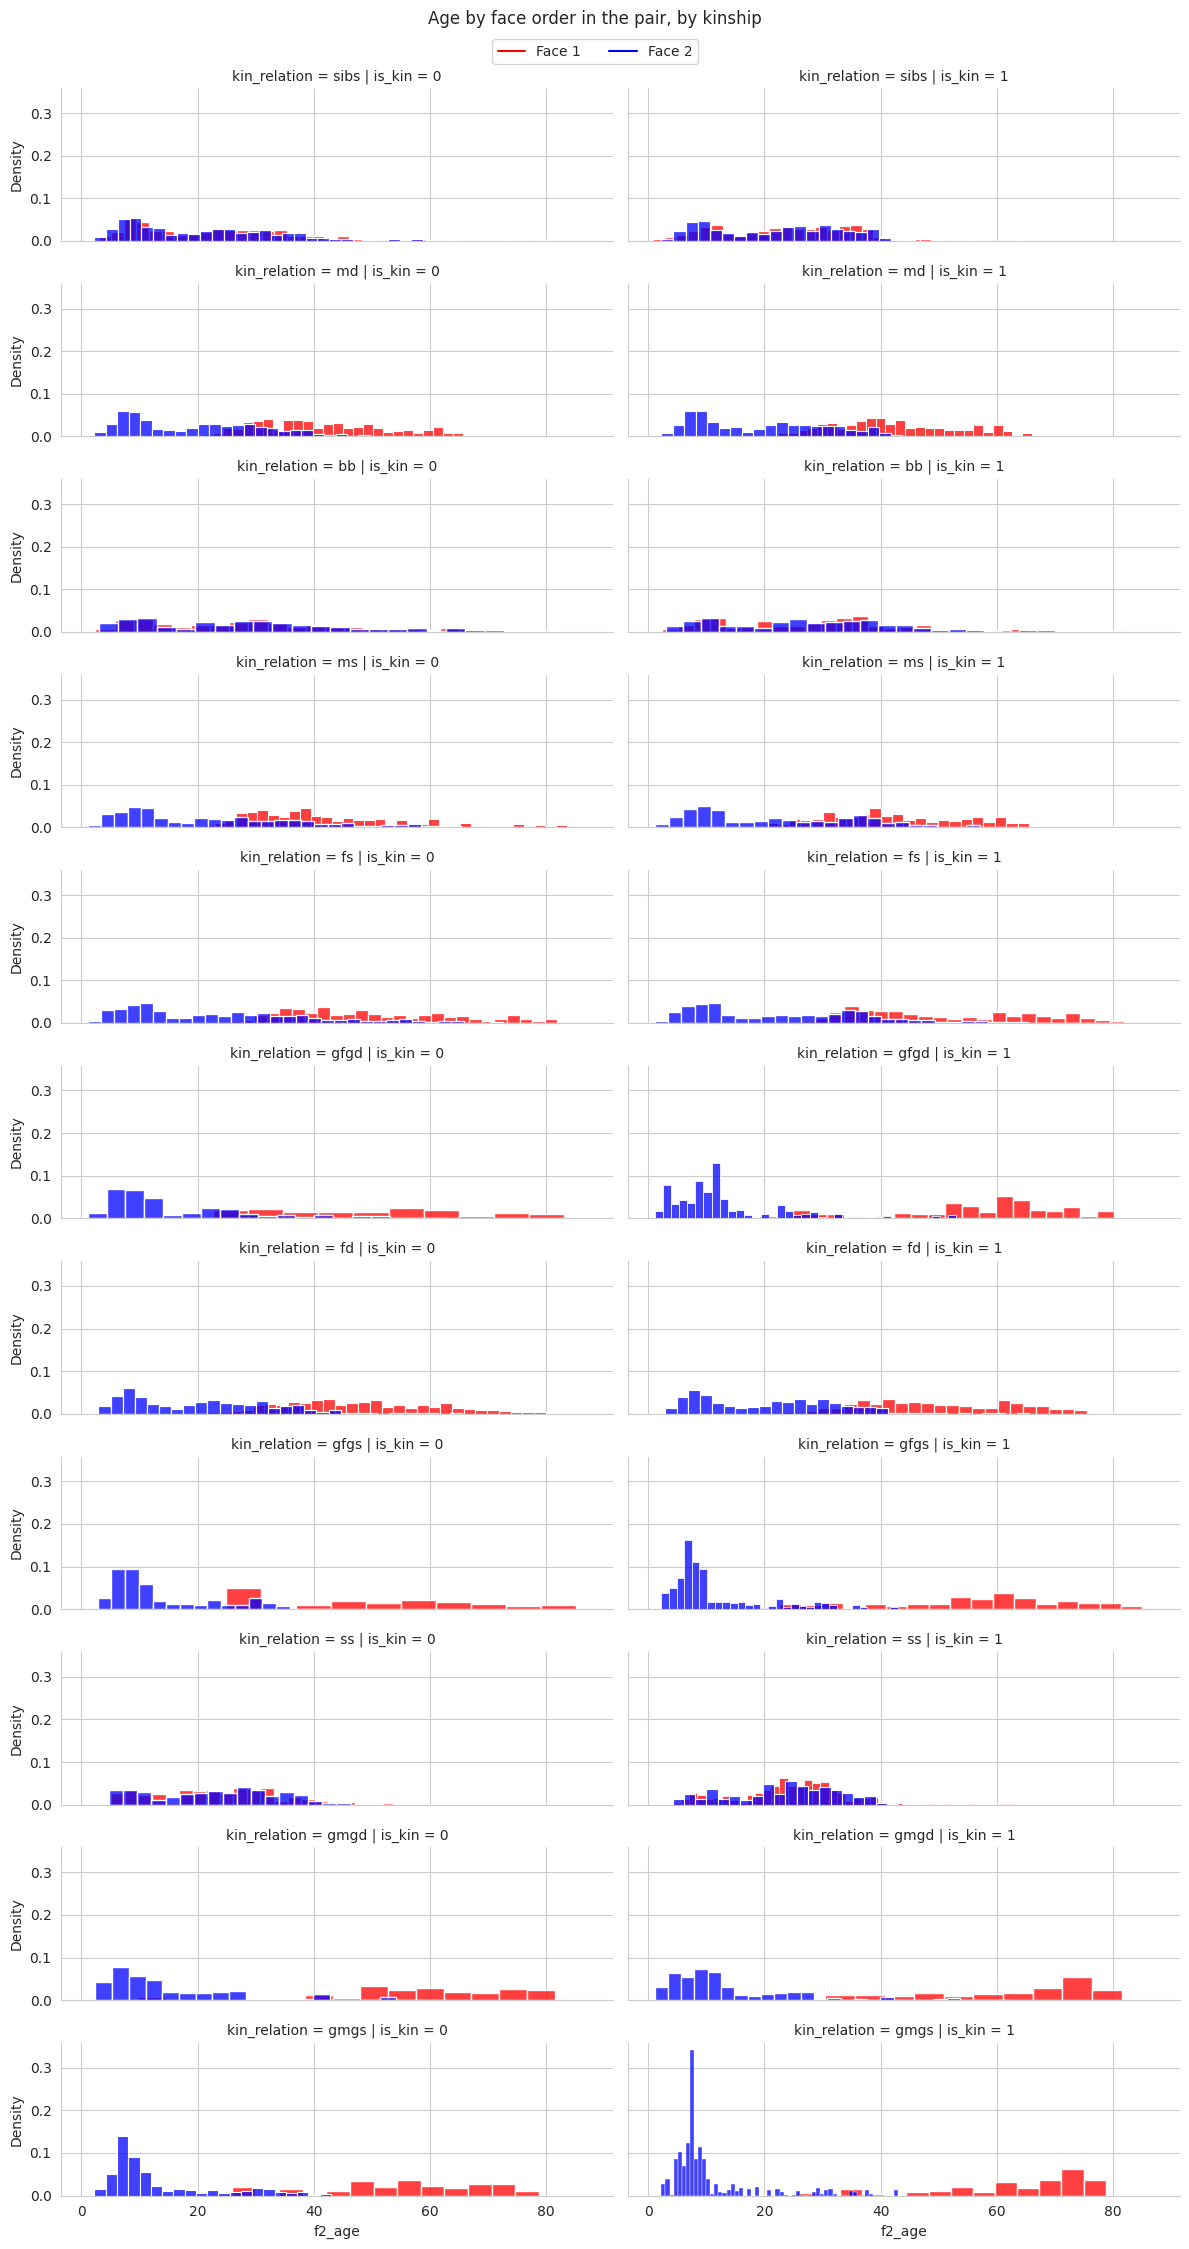

In [193]:
g = sns.FacetGrid(val_pairs, col="is_kin", row="kin_relation", height=2, aspect=3)
g = g.map(sns.histplot, "f1_age", color="red", stat="density")
g = g.map(sns.histplot, "f2_age", color="blue", stat="density")

# Create custom lines for the legend
red_line = mlines.Line2D([], [], color="red", label="Face 1")
blue_line = mlines.Line2D([], [], color="blue", label="Face 2")

# Adding the legend at the top
g.fig.legend(handles=[red_line, blue_line], loc="upper center", bbox_to_anchor=[0.5, 1.01], ncol=2)

plt.suptitle("Age by face order in the pair, by kinship", y=1.02)
plt.show()

### Compute age difference (delta)

In [196]:
val_pairs["delta_age"] = abs(val_pairs.f1_age - val_pairs.f2_age)
val_pairs[["f1_age", "f2_age", "delta_age"]]

,f1_age,f2_age,delta_age
0,61.14,10.2,50.94
1,54.70,10.2,44.50
2,27.06,10.2,16.86
3,27.06,10.2,16.86
4,29.85,10.2,19.65
...,...,...,...
99968,60.59,33.0,27.59
99969,48.21,33.0,15.21
99970,38.85,33.0,5.85
99971,52.72,33.0,19.72


### Plot age difference

/home/warley/.virtualenvs/mivolo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


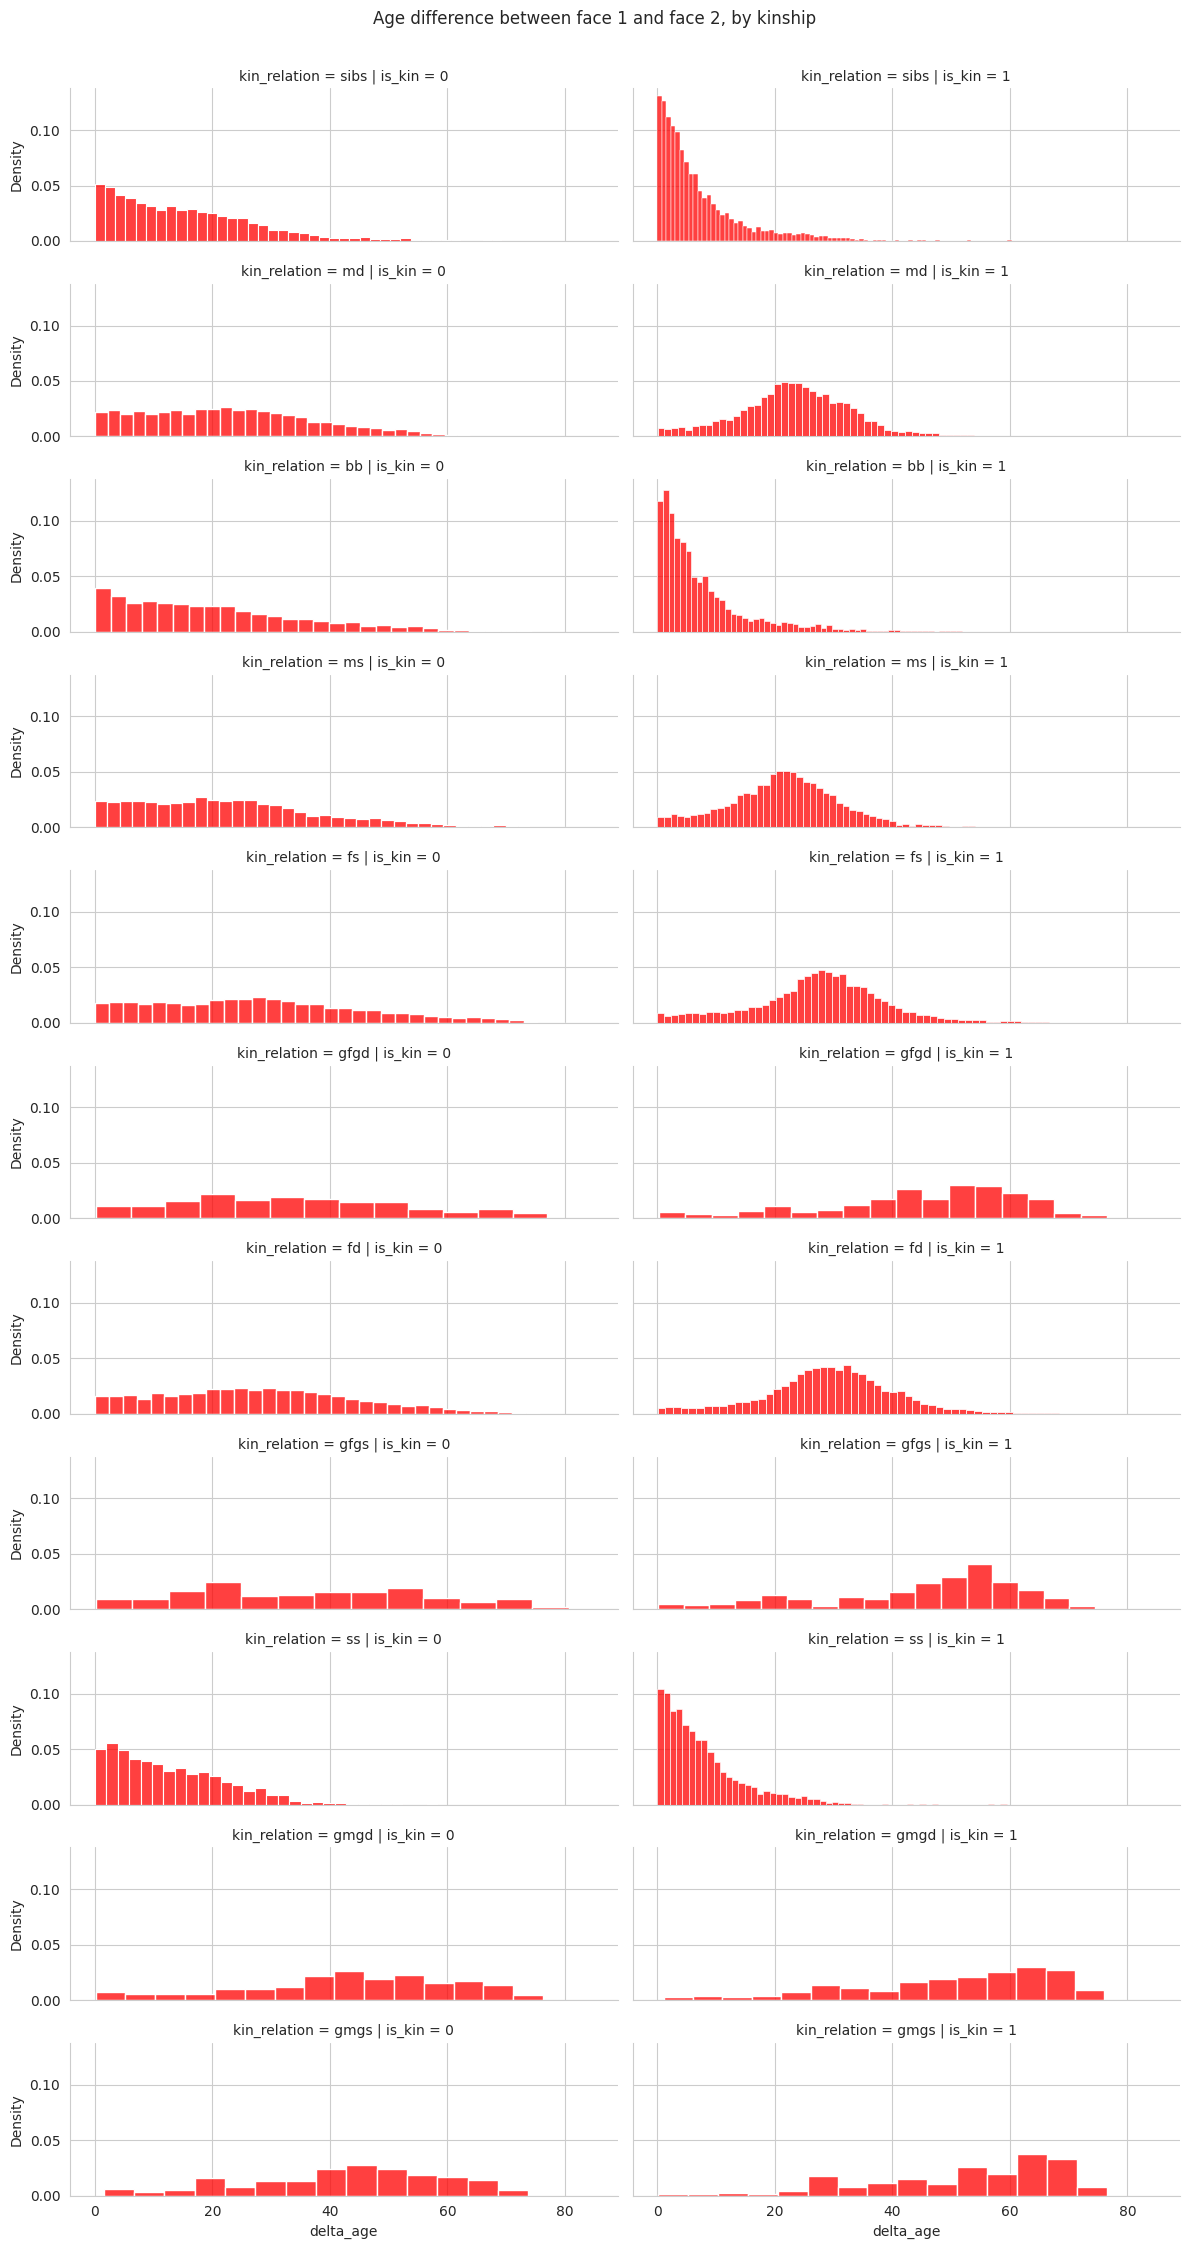

In [197]:
g = sns.FacetGrid(val_pairs, col="is_kin", row="kin_relation", height=2, aspect=3)
g = g.map(sns.histplot, "delta_age", color="red", stat="density")

plt.suptitle("Age difference between face 1 and face 2, by kinship", y=1.02)
plt.show()

### Gender by face order in the pair, by kinship

/home/warley/.virtualenvs/mivolo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/warley/.virtualenvs/mivolo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


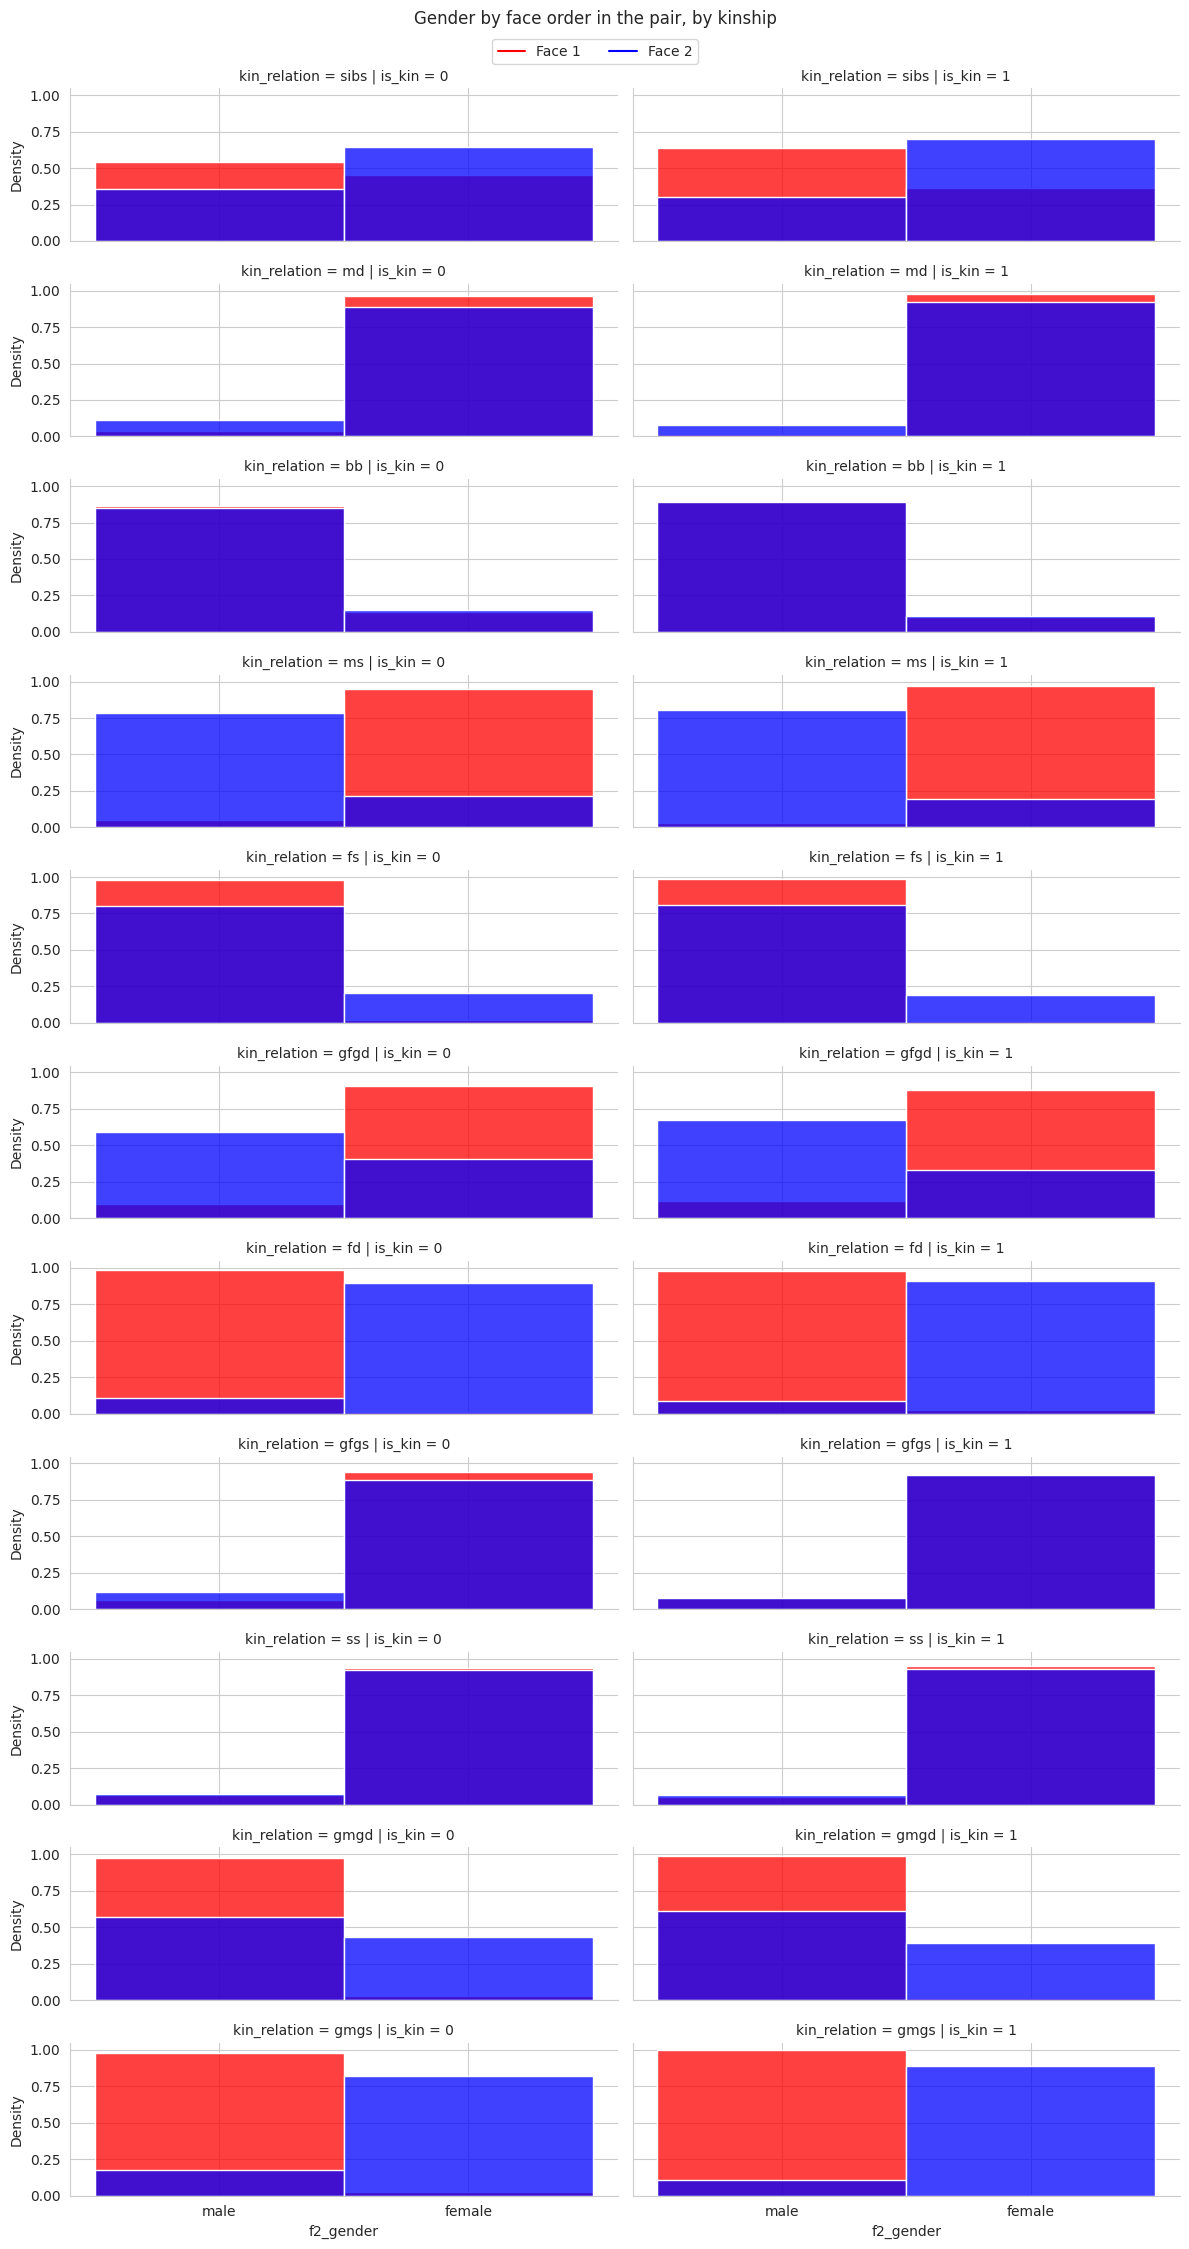

In [192]:
g = sns.FacetGrid(val_pairs, col="is_kin", row="kin_relation", height=2, aspect=3)
g = g.map(sns.histplot, "f1_gender", color="red", stat="density")
g = g.map(sns.histplot, "f2_gender", color="blue", stat="density")

# Create custom lines for the legend
red_line = mlines.Line2D([], [], color="red", label="Face 1")
blue_line = mlines.Line2D([], [], color="blue", label="Face 2")

# Adding the legend at the top
g.fig.legend(handles=[red_line, blue_line], loc="upper center", bbox_to_anchor=[0.5, 1.01], ncol=2)

plt.suptitle("Gender by face order in the pair, by kinship", y=1.02)
plt.show()

- In the above plot note that each y-axis is aggregated as an density, which means that the total area is normalized to 1.

## Computa